In [11]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import creep_event_picker as cep
import obspy
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import math
%matplotlib inline
from numba import jit

In [2]:
def check_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(path, exist_ok=True)

Import creepmeter database

In [ ]:
Creepmeter_dataframe = pd.read_excel('../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe['File_code']!='xmr_1'].index,inplace=True)
#Creepmeter_dataframe.drop([1],inplace=True)
Creepmeter_dataframe.reset_index(inplace=True,drop=True)
Creepmeter_dataframe

In [4]:
cutter = 2
n=10
cmap = cmc.roma #select the colormap

slicedCM = cmap(np.linspace(0, 1, cutter+1)) #list of colors that make up the colormap, can be called by using slicedCM[j] where j is the loop number in the fore loop

In [ ]:
df_all = pd.read_csv("../../Data/all_creep_event_picks_new_qc_Oct_02_2024.csv",index_col=0)

columns = df_all.columns.tolist()
columns.append('Quality_check_final')

try:
    df_new_qc = pd.read_csv('../../Data/QCed_creep_event_catalogue_test.csv',index_col=0)
except FileNotFoundError:
    df_new_qc = pd.DataFrame(columns=columns)
df_new_qc

In [ ]:

plt.close('all')
for i in range(len(Creepmeter_dataframe)):
    print('gathering info for {k}'.format(k=Creepmeter_dataframe.File_code.iloc[i]))
    network = Creepmeter_dataframe.Network.iloc[i]
    file_code = Creepmeter_dataframe.File_code.iloc[i]
    if file_code in list(df_new_qc['File_code']):
        print("Alread Qc'ed")
    else:
        path = "../../Data/{p}/SAC/{q}.SAC".format(p=network,q =file_code)
        path_save = "../../Data/{p}/Picks/".format(p=network)
        check_dir(path_save)
        print(path)

        print('reading & processing SAC data')

        st = obspy.read(path)
        tr = st[0]
        tr.interpolate(sampling_rate=tr.stats.sampling_rate)
        tm = tr.times("utcdatetime")
        creep = tr.data
        sample_rate =  round(tr.stats.delta)/60
        tm_dt = []
        for w in range(len(tm)):
            tm_new = tm[w].datetime
            tm_dt.append(tm_new)
        tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate,5)
        
        print('Identifying events')
        df_picks = df_all[df_all['File_code']==file_code]
        df_picks.reset_index(inplace=True,drop=True)  
    
        df_end=df_picks['ET']
        df_start=df_picks['ST']

        print('beginning QC for {k}'.format(k=file_code))
        QC = []
        for p in range(len(df_picks)):
            start = df_start.iloc[p]
            end = df_end.iloc[p]
            fig = plt.figure(figsize=(5,5))
            ax = plt.subplot(1,1,1)

            fig.suptitle('events {a} of {c}'.format(a = p+1,c =len(df_picks) ))
            boolarr_selecta = np.logical_and(np.array(tm_int)>=pd.to_datetime(start).replace(tzinfo=None)
                                            -dt.timedelta(hours=3),np.array(tm_int)<=pd.to_datetime(end).replace(tzinfo=None)
                                            +dt.timedelta(hours = 3))
            tm_selecta = tm_int[boolarr_selecta]
            tm_selecta = (tm_selecta - tm_selecta[0])/np.timedelta64(1, 'h')
            creep_selecta = creep_int[boolarr_selecta]
            creep_selecta = creep_selecta - creep_selecta[0]
            plt.plot(tm_selecta,creep_selecta,color='b')

            ax.axvspan(tm_selecta[0]+3, tm_selecta[-1]-3, color='orange', alpha=0.2)
            plt.xlabel('Hours')
            plt.ylabel('mm')
        
            fig.tight_layout()
            plt.show()
            ##### QC ####
            print('{m}/{n}'.format(m=p+1,n=len(df_picks)))         
                
            while True:
                user_input = input("Is this event a creep event? (y/n): ").strip().lower()

                if user_input == 'y':
                    QC.append('CE')
                    print("Creep event identified")
                    # Do something for "yes"
                    break
                elif user_input == 'n':
                    QC.append('NCE')
                    print("This event is not a creep event")
                    # Do something for "esc" or just exit
                    break
                else:
                    print("Invalid input! Please enter 'y' to proceed or 'n' to exit.")
            
        

            plt.close() 

        
        df_picks['Quality_check_final'] = QC
        print(df_picks)
        print('QC completed')
        df_new_qc = pd.concat([df_new_qc,df_picks],ignore_index=True)

In [ ]:
df_new_qc

In [8]:
df_new_qc.drop(df_new_qc[df_new_qc['Quality_check_final']!='CE'].index,inplace=True)

In [9]:
df_new_qc.to_csv('../../Data/QCed_creep_event_catalogue_test.csv')

In [24]:
@jit(nopython=True, error_model='numpy')
def covarience_cal(matrix_row_i, matrix_row_j):
    covarience = np.sum((matrix_row_i - np.mean(matrix_row_i)) * (matrix_row_j - np.mean(matrix_row_j))) / (
                len(matrix_row_i) - 1)
    return covarience


@jit(nopython=True, error_model='numpy')
def covariance_matrix_maker(data_matrix,covariance_matrix):
    #covariance_matrix = np.zeros((len(data_matrix), len(data_matrix)))
    for i in range(len(data_matrix)):
        for j in range(i, len(data_matrix)):
            cov_sel_rows = covarience_cal(data_matrix[i], data_matrix[j])
            covariance_matrix[i, j] = covariance_matrix[j, i] = cov_sel_rows
    return covariance_matrix

In [25]:
path = "../../Data/{p}/SAC/{q}.SAC".format(p=network,q =file_code)
st = obspy.read(path)
tr = st[0]
tr.interpolate(sampling_rate=tr.stats.sampling_rate)
tm = tr.times("utcdatetime")
creep = tr.data
sample_rate =  round(tr.stats.delta)/60
tm_dt = []
for w in range(len(tm)):
    tm_new = tm[w].datetime
    tm_dt.append(tm_new)
tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate,5)

/Users/dagi9522/Library/CloudStorage/OneDrive-UCB-O365/Documents/GitHub/Creep_event_detection_scripts/creep_event_picker.py:638: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = upsampled.interpolate(method='ffill') #interpolate the dataset to get a continious record evenly spaced at 10 mins


In [37]:
print(len(df_new_qc))

43


In [90]:
for i in range(len(df_new_qc)):
    boolarr = np.logical_and(tm_int>=pd.to_datetime(df_new_qc['ST'].iloc[i]),tm_int<=pd.to_datetime(df_new_qc['ST'].iloc[i])+dt.timedelta(hours=44))
    creep_event = creep_int[boolarr]
    creep_event = (creep_event-creep_event[0])/15
    if i ==0:
        creep_events_matrix = creep_event
    else:
        creep_events_matrix = np.vstack([creep_events_matrix, creep_event])
creep_events_matrix = creep_events_matrix.T

In [91]:
60*44

2640

In [92]:
covariance_matrix = np.zeros((len(creep_events_matrix), len(creep_events_matrix)))
covariance_matrix = covariance_matrix_maker(creep_events_matrix,covariance_matrix)

In [93]:
import cmcrameri.cm as cmc

In [94]:
C_matrix = np.load("../../Data/Central_San_Andreas_Fault/Cov_matrix/xmr_1_cov_matrix_max_duration_mean.npy")
C_matrix = C_matrix[0:len(covariance_matrix),0:len(covariance_matrix)]
#vmax = np.max(C_matrix)
vmin = np.min([np.min(C_matrix),np.min(covariance_matrix)])
vmax = np.max([np.max(C_matrix),np.max(covariance_matrix)])
print(np.max(np.max(covariance_matrix)/np.max(C_matrix)))

0.5521438172164465


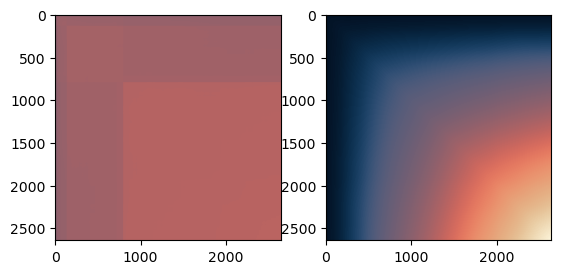

In [95]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(covariance_matrix,cmap=cmc.lipari,vmax=vmax,vmin=vmin)
plt.subplot(1,2,2)
plt.imshow(C_matrix,cmap=cmc.lipari,vmax=vmax,vmin=vmin)
plt.show()

In [14]:
np.mean(df_new_qc['Duration, hrs'])

43.694573643410855

In [15]:
np.max(df_new_qc['Duration, hrs'])

335.6666666666667

In [18]:
tm_int>=df_new_qc['ST']

ValueError: ('Lengths must match to compare', (43,), (2413997,))